In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

## Data Preparation

In [2]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
lq45_dir = '/workspace/202205_idx-trading/_data/20220525_lq45/'
lq45_index_file = data_dir + '20220525_lq45_index.csv'
lq45_list = '20220525_lq45-list.txt'
issi_list = '20220525_issi-list.txt'

# Prepare Stock Tickers
with open(data_dir + lq45_list, "r") as f:
    lq45_tickers = f.read().split('\n')

with open(data_dir + issi_list, "r") as f:
    issi_tickers = f.read().split('\n')

## (Alternatively) Select only Halal lq45 tickers using issi tickers
halal_lq45_tickers = [f for f in lq45_tickers if f in issi_tickers]

## Prepare active tickers for international codes
active_tickers_international = [f + '.JK' for f in lq45_tickers]
halal_active_tickers_international = [f + '.JK' for f in halal_lq45_tickers]

In [3]:
# Read downloaded stock Adjusted Close Price data
lq45_df_dict = {}
for ticker in tqdm(active_tickers_international):
    lq45_df_dict[ticker] = pd.read_csv(lq45_dir + ticker + '.csv')
    
lq45_index_data = pd.read_csv(lq45_index_file)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 133.09it/s]


In [4]:
# Do Some basic data Operations (Fill NaN and Filter Dates)
date_start = '2012-01-01'

for ticker in tqdm(active_tickers_international):
    # Fill NaN values with the earliest data
    lq45_df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    
    # Filter To Only Dates after Certain Period
    lq45_df_dict[ticker]['Date'] = pd.to_datetime(lq45_df_dict[ticker]['Date'])
    lq45_df_dict[ticker] = lq45_df_dict[ticker][lq45_df_dict[ticker]['Date'] >= date_start]
    
    # Reset Index After Dropped
    lq45_df_dict[ticker] = lq45_df_dict[ticker].reset_index(drop=True)

# Do the same for lq45 index data
lq45_index_data.fillna(method='bfill', axis=0, inplace=True)
lq45_index_data['Date'] = pd.to_datetime(lq45_index_data['Date'])
lq45_index_data = lq45_index_data[lq45_index_data['Date'] >= date_start]
lq45_index_data = lq45_index_data.reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 358.67it/s]


## Strategy

### Baseline Strategy

Buy and Hold LQ45

In [7]:
# Simple buy and hold strategy
b_df = lq45_index_data.copy()

b_df['signal'] = ''
b_df['close'] = b_df['Adj Close']
b_df = b_df[['Date', 'close', 'signal']]
b_df = b_df.reset_index(drop=True)

b_df['signal'][0] = 'buy'
b_df['signal'][len(b_df)-1] = 'sell'

def calc_returns(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.
    Is strategy specific.
    '''
    last_signal = ''
    df['return'] = ''
    for i in range(0, len(df)):
        if last_signal == 'buy':
            df["return"][i] = (df['close'][i] / df['close'][i-1]) - 1
        elif last_signal == 'sell':
            df["return"][i] = 0
        else:
            df["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df["signal"][i] 

    df["cum_return"] = (1 + df["return"]).cumprod()
    return df

### Trading Strategy
EP Chan's Buy on Gap strategy
https://medium.com/@financialnoob/buy-on-gap-strategy-and-its-performance-over-time-2a474a25cf2e

Implementation uses open and close. Not quite correct, if we analyze the charts for all the stocks. But close enough. Ideally you'd have adjusted open data.

In [ ]:
# Explore Stock Charts
for ticker in active_tickers_international:
    lq45_df_dict[ticker].set_index('Date')['Adj Close'].plot()
    lq45_df_dict[ticker].set_index('Date')['Close'].plot()
    plt.show()
    print(ticker)
    time.sleep(2)

In [8]:
# Define Strategy
def strategy_and_returns(df_dict, tickers):
    
    def buy_signal(ol_ret, cc_ret_std, open_now, close_sma):
        if ((ol_ret < cc_ret_std) and (open_now > close_sma)):
            return True
        else:
            return False
    
    # Generate TA Indicators
    for ticker in tqdm(tickers):
        # Take only the important columns
        df_dict[ticker]['close'] = df_dict[ticker]['Close']
        df_dict[ticker]['open'] = df_dict[ticker]['Open']
        df_dict[ticker]['low'] = df_dict[ticker]['Low']
        df_dict[ticker]['ol_return'] = np.nan
        df_dict[ticker]['cc_return'] = np.nan
        
        for i in range(1, len(df_dict[ticker])):
            df_dict[ticker]['ol_return'][i] = (df_dict[ticker]['open'][i] / df_dict[ticker]['low'][i-1]) - 1
            df_dict[ticker]['cc_return'][i] = (df_dict[ticker]['close'][i] / df_dict[ticker]['close'][i-1]) - 1
        
        df_dict[ticker] = df_dict[ticker][['Date', 'close', 
                                           'open', 'low', 
                                           'ol_return', 'cc_return']]

        # Generate 90-day std of daily returns

        df_dict[ticker]['STDEV_90'] = ta.stdev(df_dict[ticker]['cc_return'], length=90, offset=1)

        # Generate 20-day standard moving average of closing prices
        df_dict[ticker]['SMA_20'] = ta.sma(df_dict[ticker]['close'], length=20, offset=1)
        df_dict[ticker].dropna(inplace=True)
        df_dict[ticker] = df_dict[ticker].reset_index(drop=True)

    # Generate Signals and Calculate Returns
    df_signal = df_dict[ticker].copy()
    df_signal['stocks'] = ''
    df_signal['return'] = np.nan
    df_signal = df_signal[['Date', 'stocks', 'return']]
    for i in tqdm(range(0, len(df_dict[ticker]))):
        
        # Filter Stocks with criteria
        stock_picks = []
        ol_returns = []
        opens = []
        closes = []
        for ticker in tickers:
            pick_stock = buy_signal(df_dict[ticker]['ol_return'][i],
                                    df_dict[ticker]['STDEV_90'][i],
                                    df_dict[ticker]['open'][i],
                                    df_dict[ticker]['SMA_20'][i])
                
            if pick_stock:
                stock_picks.append(ticker)
                ol_returns.append(df_dict[ticker]['ol_return'][i])
                opens.append(df_dict[ticker]['open'][i])
                closes.append(df_dict[ticker]['close'][i])
                
        df_stock_picks = pd.DataFrame({
                                        'stocks': stock_picks,
                                        'ol_return': ol_returns,
                                        'open': opens,
                                        'close': closes
                                     })
                
        # Select 10 stocks with lowest cl returns, calculate the returns on close
        if len(df_stock_picks) == 0:
            ret = 0
        else:
            if len(df_stock_picks) > 10:
                df_stock_picks = df_stock_picks.nsmallest(10, columns='ol_return')
        
            df_stock_picks['oc_return'] = (df_stock_picks['close'] / df_stock_picks['open']) - 1
            ret = sum(df_stock_picks['oc_return'])/len(stock_picks)
        
        df_signal['stocks'][i] = df_stock_picks['stocks']
        df_signal['return'][i] = ret
        
    df_signal["cum_return"] = (1 + df_signal["return"]).cumprod()
    
    return df_signal

In [9]:
# Run Strategy
s_df = strategy_and_returns(lq45_df_dict, active_tickers_international)

100%|██████████████████████████████████████████████████████████████| 2490/2490 [00:10<00:00, 241.39it/s]


## Evaluation

### Calculate Metrics for Strategy

In [10]:
# Prepare for Metric Calculation
s_ret = s_df.set_index('Date')['return'].astype(float)

b_df = calc_returns(b_df)
b_ret = b_df.set_index('Date')['return'].astype(float)

# Calculate Metrics
qs.reports.metrics(returns=s_ret, benchmark=b_ret, rf=0.025, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2012-05-11  2012-05-11
End Period          2022-05-25  2022-05-25
Risk-Free Rate      2.5%        2.5%
Time in Market      82.0%       98.0%

Cumulative Return   19.68%      44.93%
CAGR﹪              1.8%        3.76%

Sharpe              0.03        0.17
Prob. Sharpe Ratio  26.57%      36.13%
Sortino             0.04        0.23
Sortino/√2          0.03        0.17
Omega               1.01        1.01

Max Drawdown        -31.87%     -49.94%
Longest DD Days     2100        1582

Gain/Pain Ratio     0.04        0.05
Gain/Pain (1M)      0.16        0.31

Payoff Ratio        0.96        0.92
Profit Factor       1.04        1.05
Common Sense Ratio  1.06        1.08
CPC Index           0.51        0.51
Tail Ratio          1.01        1.02
Outlier Win Ratio   6.63        3.55
Outlier Loss Ratio  5.01        3.45

MTD                 3.42%       -6.99%
3M                  -1.75%      3.6

### Plot Relevant Visualizations

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


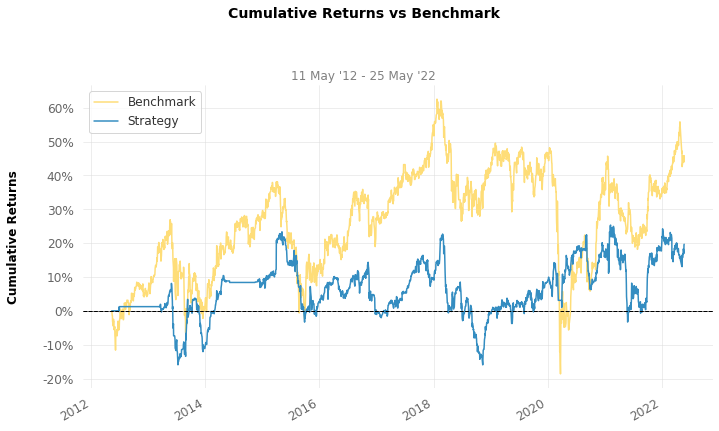

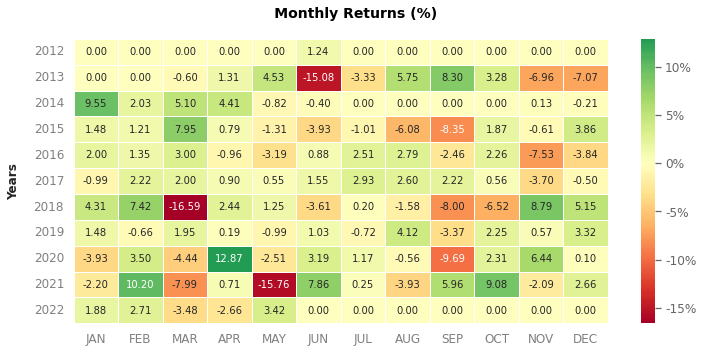

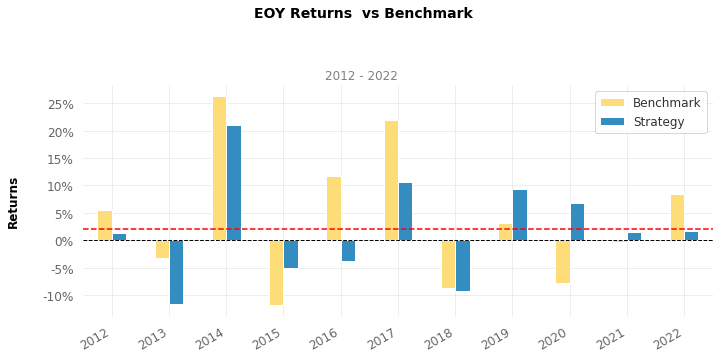

In [11]:
# Returns Visualization
qs.plots.returns(s_ret, b_ret)
qs.plots.monthly_heatmap(s_ret)
qs.plots.yearly_returns(s_ret, b_ret)

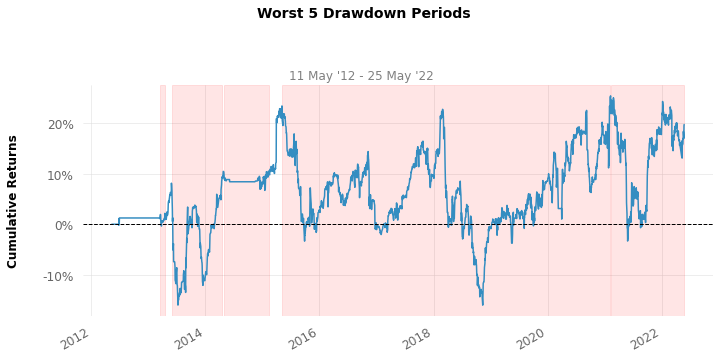

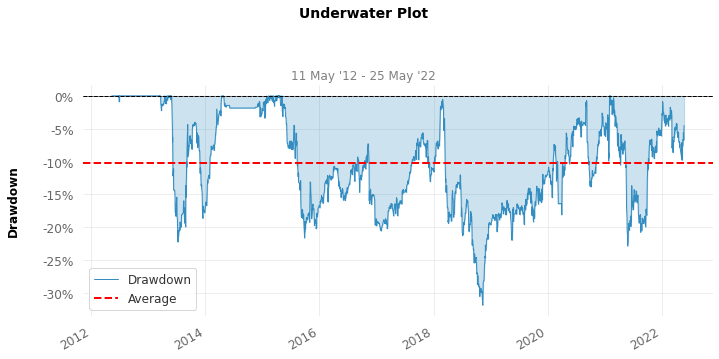

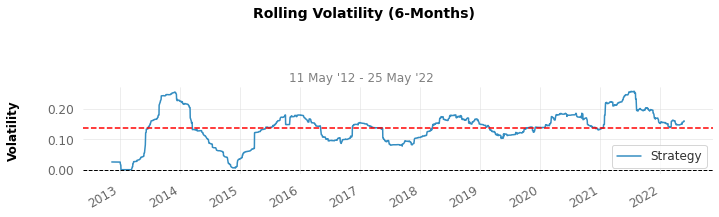

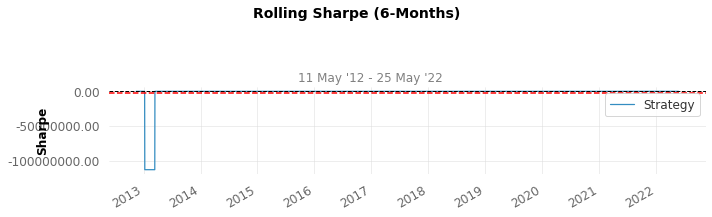

In [12]:
# Risk Visualization
qs.plots.drawdowns_periods(s_ret)
qs.plots.drawdown(s_ret)
qs.plots.rolling_volatility(s_ret)
qs.plots.rolling_sharpe(s_ret, rf=0.025)